# AEWS Python Notebook 02: Landsat data and PQ flags

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: 14 April 2016 (slight updates: 28 April 2016, 15 July 2016)

**Note:** The Python code below is "rudimentary". It does not make use of the API's Analytics / Execution Engines, nor is it optimised to take advantage of the subtleties of Python's `xarray`s, etc. Priority is here given to code  interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).


## Summary

In this notebook, we introduce / review the following concepts:

* quering and loading up Landsat NBAR data
* loading up the corresponding PQ data
* creating a PQ mask and applying it to the Landsat image.

## Preliminaries

This Jupyter notebook demonstrates the basic functionality of using PQ flags of associated Landsat data using the AGDC v2 API. At the time of writing (April 2016) there are no dedicated PQ functions available in the AGDC v2.0 API. The code below thus uses a "manual" approach, that will likely be superseded in the near future once more API functions become available.

This (Jupyter) notebook was written for use on the NCI's VDI system, with pre-loaded module:
```
$ module use /g/data/v10/public/modules/modulefiles --append
$ module load agdc-py2-dev
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from __future__ import print_function

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10   # increase plot size a bit...

# import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) module
import datacube.api

Let's also re-load our array scaling function from our previous notebook "AEWS Python Notebook 01":

In [2]:
def scale_array(arr, prcnt, min_val, max_val, nan_val):
    # Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val' and 'max_val', 
    # replacing 'nan_val' values with NaN's.
    f_arr = arr.astype('float')    # required for NaN's 
    f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    return f_arr

## Checking available datasets

Use the functions `list_fields()` and `list_field_values(field)` to list all the fields that can be searched and their values found in the database.

In [3]:
dc = datacube.api.API()
dc.list_fields()

[u'product',
 u'lat',
 u'sat_path',
 u'platform',
 u'lon',
 u'orbit',
 'collection',
 u'instrument',
 u'sat_row',
 u'time',
 u'gsi',
 'id']

In [4]:
print( dc.list_field_values('product') )
print( dc.list_field_values('platform') )

[u'PQ', u'NBAR']
[u'LANDSAT_5']


So we have both NBAR and associated PQ datasets available. Let's investigate those datasets.

In [5]:
query = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
}
desc = dc.get_descriptor(query, include_storage_units=False)
pprint(desc)

{u'ls5_nbar_albers': {'dimensions': [u'time', u'y', u'x'],
                      'irregular_indices': {u'time': array(['1990-03-03T10:11:16.000000000+1100',
       '1990-03-03T10:11:39.000000000+1100',
       '1990-04-04T09:10:42.000000000+1000', ...,
       '1996-11-14T10:11:26.000000000+1100',
       '1996-11-30T10:11:47.000000000+1100',
       '1996-11-30T10:12:11.000000000+1100'], dtype='datetime64[ns]')},
                      'result_max': (numpy.datetime64('1996-11-30T10:12:11.000000000+1100'),
                                     -1100012.5,
                                     2299987.5),
                      'result_min': (numpy.datetime64('1990-03-03T10:11:16.000000000+1100'),
                                     -4999987.5,
                                     -1999987.5),
                      'result_shape': (1051, 156000, 172000),
                      'variables': {u'band_10': {'datatype_name': dtype('int16'),
                                                 'nodata_va

In [6]:
query = {
    'product': 'PQ',
    'platform': 'LANDSAT_5',
}
desc = dc.get_descriptor(query, include_storage_units=False)
pprint(desc)

{u'ls5_pq_albers': {'dimensions': [u'time', u'y', u'x'],
                    'irregular_indices': {u'time': array(['1990-03-03T10:11:16.000000000+1100',
       '1990-03-03T10:11:39.000000000+1100',
       '1990-04-04T09:10:42.000000000+1000', ...,
       '1996-11-14T10:11:26.000000000+1100',
       '1996-11-30T10:11:47.000000000+1100',
       '1996-11-30T10:12:11.000000000+1100'], dtype='datetime64[ns]')},
                    'result_max': (numpy.datetime64('1996-11-30T10:12:11.000000000+1100'),
                                   -1100012.5,
                                   2299987.5),
                    'result_min': (numpy.datetime64('1990-03-03T10:11:16.000000000+1100'),
                                   -4999987.5,
                                   -1999987.5),
                    'result_shape': (1050, 156000, 172000),
                    'variables': {u'band_pixelquality': {'datatype_name': dtype('int16'),
                                                         'nodata_valu

For some reason, we have 1 fewer PQ date compared to the NBAR dates (1050 vs. 1051), but we'll leave this to the GA guys to sort out. For now let's just assume the data are consistent.

## Data access

Let's try to load up the NBAR and PQ data. We'll re-use the Lake Burley-Griffin example from the previous notebook "AEWS Python Notebook 01". We'll also use the `get_data()` data access method.

### Loading the Landsat data

In [7]:
NBARquery = {
    'product': 'NBAR',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (149.0, 149.22) },
        'y' : { 'range': (-35.22, -35.38) },
        'time': { 'range': ((1996, 1, 1), (1996, 7 ,1)) }
    }
}
NBARdata = dc.get_data( NBARquery )       # returns a dictionary

In [8]:
print( NBARdata['dimensions'] )
print( NBARdata['size'] )                   # time,x,y sizes/lengths
print( NBARdata['indices']['time'] )        # time indices

[u'time', u'y', u'x']
(11, 812, 887)
['1996-01-31T09:54:41.500000000+1100' '1996-01-31T09:55:05.500000000+1100'
 '1996-02-16T09:56:11.000000000+1100' '1996-03-03T09:57:15.500000000+1100'
 '1996-04-04T08:58:54.000000000+1000' '1996-04-04T08:59:18.000000000+1000'
 '1996-04-20T08:59:53.000000000+1000' '1996-04-20T09:00:17.000000000+1000'
 '1996-05-22T09:01:46.000000000+1000' '1996-05-22T09:02:10.000000000+1000'
 '1996-06-07T09:02:40.000000000+1000']


Load up and scale the Landsat data:

In [9]:
date_ind = 2
B2data = NBARdata['arrays']['band_20'].isel(time=date_ind).values    # numpy.ndarray
B4data = NBARdata['arrays']['band_40'].isel(time=date_ind).values
B5data = NBARdata['arrays']['band_50'].isel(time=date_ind).values
sB2data = scale_array(B2data, 99.0, 0, 255, -999)
sB4data = scale_array(B4data, 99.0, 0, 255, -999)
sB5data = scale_array(B5data, 99.0, 0, 255, -999)
y_size = NBARdata['size'][1]
x_size = NBARdata['size'][2]

In [10]:
# False colour image, using integers for better compatibility with plt.imshow()
FC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
FC_image[:,:,0] = sB5data
FC_image[:,:,1] = sB4data
FC_image[:,:,2] = sB2data

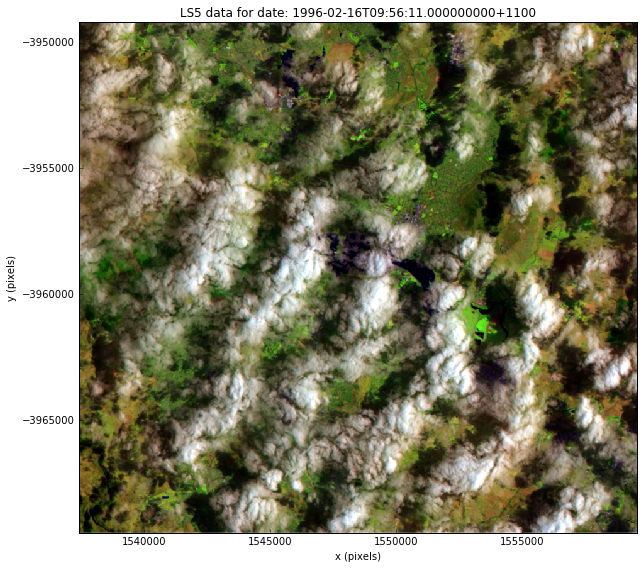

In [11]:
cur_date = NBARdata['indices']['time'][date_ind]
xvec = NBARdata['indices']['x']
yvec = NBARdata['indices']['y']
plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
#plt.axis('image')
plt.title('LS5 data for date: {}'.format(cur_date))
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')

This should provide a good example for testing the PQ masking!

### Loading the PQ data

In [12]:
PQquery = {
    'product': 'PQ',
    'platform': 'LANDSAT_5',
    'dimensions': {
        'x' : { 'range': (149.0, 149.22) },
        'y' : { 'range': (-35.22, -35.38) },
        'time': { 'range': ((1996, 1, 1), (1996, 7 ,1)) }
    }
}
PQdata = dc.get_data( PQquery )       # returns a dictionary

In [13]:
print( PQdata.keys() )
print( PQdata['dimensions'] )
print( PQdata['size'] )                   # time,x,y sizes/lengths
print( PQdata['indices']['time'] )        # time indices

['dimensions', 'arrays', 'element_sizes', 'indices', 'coordinate_reference_systems', 'size']
[u'time', u'y', u'x']
(11, 812, 887)
['1996-01-31T09:54:41.500000000+1100' '1996-01-31T09:55:05.500000000+1100'
 '1996-02-16T09:56:11.000000000+1100' '1996-03-03T09:57:15.500000000+1100'
 '1996-04-04T08:58:54.000000000+1000' '1996-04-04T08:59:18.000000000+1000'
 '1996-04-20T08:59:53.000000000+1000' '1996-04-20T09:00:17.000000000+1000'
 '1996-05-22T09:01:46.000000000+1000' '1996-05-22T09:02:10.000000000+1000'
 '1996-06-07T09:02:40.000000000+1000']


In [14]:
# Ensure we've got the same date as the Landsat data...
PQcur_date = PQdata['indices']['time'][date_ind]
print( "Do we have the same dates?", PQcur_date==cur_date )

Do we have the same dates? True


[[16383 16383 16383 ..., 16383 16383 16383]
 [16383 16383 16383 ..., 16383 16383 16383]
 [16383 16383 16383 ..., 16383 16383 16383]
 ..., 
 [16383 16383 16383 ..., 14335 14335 14335]
 [16383 16383 16383 ..., 13311 13311 13311]
 [16383 16383 16383 ..., 13311 13311 13311]]


Unique values in the PQ array: [ 4095  8191 10239 12287 13294 13310 13311 14335 15359 16383]


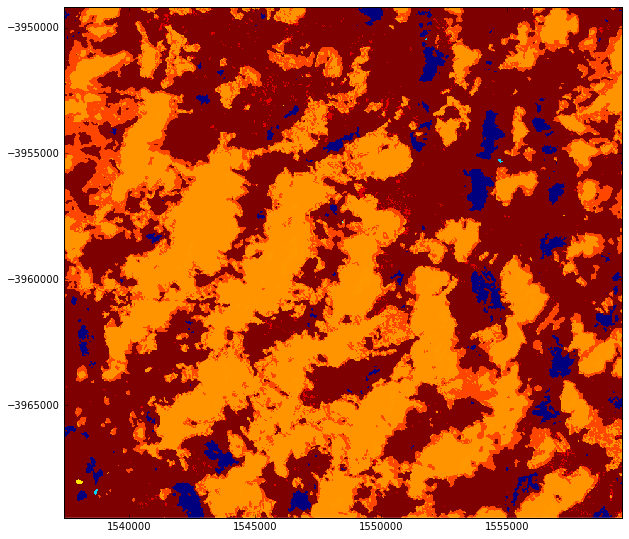

In [15]:
PQarray = PQdata['arrays']['band_pixelquality'].isel(time=date_ind).values
print( PQarray ); print('\n')
print( "Unique values in the PQ array:", np.unique(PQarray) )
plt.imshow(PQarray, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)

OK, this looks like PQ flags indeed. Now to work out which bit does what... something that will likely become more intuitive once there actually is some API v2.0 documentation. The little bit of info found on GitHub regarding PQ flags indicates that the PQ information looks like this:

* bit_index: 13 -- Cloud Shadow (Fmask)
* bit_index: 12 -- Cloud Shadow (ACCA)
* bit_index: 11 -- Cloud (Fmask)
* bit_index: 10 -- Cloud (ACCA)
* bit_index: 9 -- 1: Land observation, 0: Sea observation
* bit_index: 8 -- All bands for this pixel contain non-null values (contiguity)
* bit_index: 7 -- Band 7 is saturated
* bit_index: 6 -- Band 6-2 is saturated
* bit_index: 5 -- Band 6-1 is saturated
* bit_index: 4 -- Band 5 is saturated
* bit_index: 3 -- Band 4 is saturated
* bit_index: 2 -- Band 3 is saturated
* bit_index: 1 -- Band 2 is saturated
* bit_index: 0 -- Band 1 is saturated

That looks pretty straightforward. However, what's perhaps not so straightforward is that the flag of a "good" pixel is set to `1`. In other words, `bit_10 = 1` means there is NO cloud. This is somewhat counter-intuitive, but this also means that the PQ flag for a 100% good pixel (i.e. clear land pixel with no saturation, no null values, no cloud and no shadow) are set to `11111111111111`, i.e. `16383` in decimal.

So let's use this fact and mask out any Landsat pixel whose PQ flag is not `16383`.

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]]


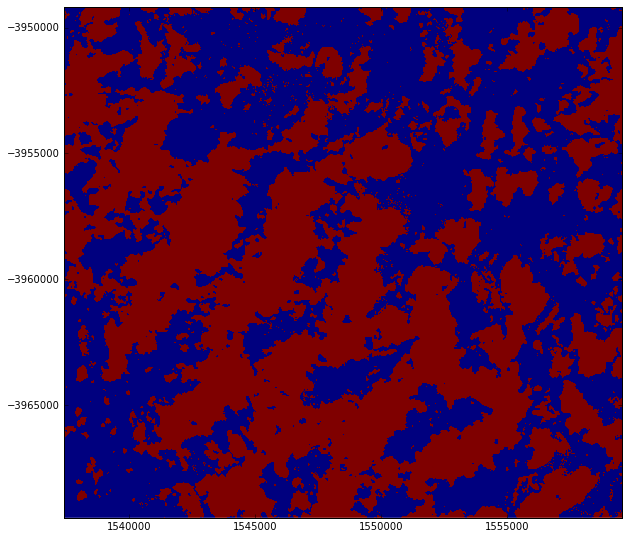

In [16]:
PQmask = ( PQarray!=16383)
print( PQmask )
plt.imshow(PQmask, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)

That looks like a semi-decent mask. Let's apply it to the data...

In [17]:
# original data
sB5data

array([[  36.19897959,   33.21428571,   35.12755102, ...,   79.24744898,
          64.05612245,   48.94132653],
       [  35.12755102,   39.9872449 ,   41.47959184, ...,   48.36734694,
          40.82908163,   38.53316327],
       [  37.61479592,   42.39795918,   44.96173469, ...,   30.57397959,
          29.61734694,   33.86479592],
       ..., 
       [  50.73979592,   61.07142857,   61.49234694, ...,  115.79081633,
         117.09183673,  124.32397959],
       [  43.58418367,   53.7627551 ,   59.3494898 , ...,  114.64285714,
         119.08163265,  134.00510204],
       [  46.875     ,   57.39795918,   61.60714286, ...,  103.7372449 ,
         108.0994898 ,  124.85969388]])

In [18]:
# let's mask areas in grey this time...
sB5data[PQmask] = 200
sB4data[PQmask] = 200
sB2data[PQmask] = 200
sB5data   # masked data

array([[  36.19897959,   33.21428571,   35.12755102, ...,   79.24744898,
          64.05612245,   48.94132653],
       [  35.12755102,   39.9872449 ,   41.47959184, ...,   48.36734694,
          40.82908163,   38.53316327],
       [  37.61479592,   42.39795918,   44.96173469, ...,   30.57397959,
          29.61734694,   33.86479592],
       ..., 
       [  50.73979592,   61.07142857,   61.49234694, ...,  200.        ,
         200.        ,  200.        ],
       [  43.58418367,   53.7627551 ,   59.3494898 , ...,  200.        ,
         200.        ,  200.        ],
       [  46.875     ,   57.39795918,   61.60714286, ...,  200.        ,
         200.        ,  200.        ]])

The relevant pixels seem to have been "removed"...

In [19]:
FC_image = np.zeros((y_size, x_size, 3), dtype='uint8')
FC_image[:,:,0] = sB5data
FC_image[:,:,1] = sB4data
FC_image[:,:,2] = sB2data

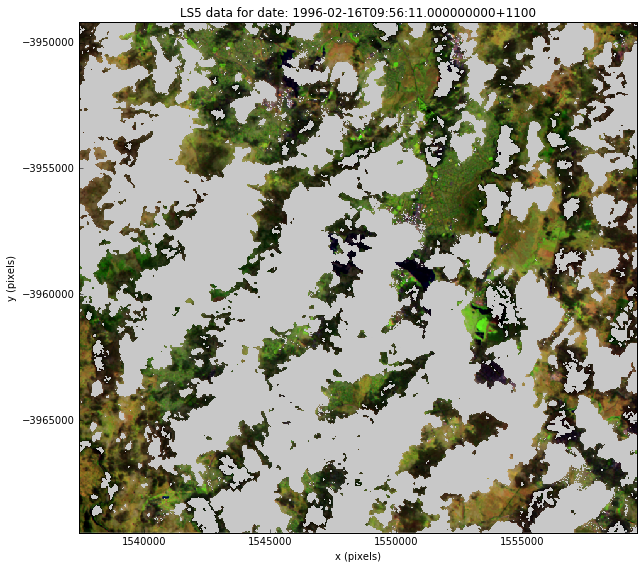

In [20]:
plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title('LS5 data for date: {}'.format(cur_date))
plt.xlabel('x (pixels)')
plt.ylabel('y (pixels)')

Well that did the job... sort-of! This mask leaves to be desired, but the point is illustrated nevertheless. This will give us some starting point for our AEWS work in any case...